El cuaderno ha sido ejecutado sobre una maquina virtual de  ubuntu arm en un MacBook Pro M1. Se hace uso de parallels, asignando 4 cores y 6 GB de RAM.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import random
from pyspark import SparkContext
import pyspark
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
sc = SparkContext("local[*]", "Name of the Program")

25/02/28 11:03:15 WARN Utils: Your hostname, ubuntu-linux-22-04-desktop resolves to a loopback address: 127.0.1.1; using 10.211.55.3 instead (on interface enp0s5)
25/02/28 11:03:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/28 11:03:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

def readFile(filename):
    rdd = sc.textFile(filename)
    rdd_numpy = rdd.map(lambda x : np.array(x.split(","), dtype = float))
    rdd_return = rdd_numpy.map(lambda x : (x[:-1], int(x[-1])))
    return rdd_return

def normalize_value(x, mean, std):
    value = (x[0] - mean) / std
    normalized_val = np.nan_to_num(value, copy=False, nan=0.0)
    return (normalized_val, x[1])

def normalize(RDD_Xy):
    
    rdd_sum = RDD_Xy.reduce(lambda x, y: (np.array(x[0]) + np.array(y[0]), x[1]))
    total_rows = float(RDD_Xy.count())
    mean = rdd_sum[0] / total_rows

    rdd_mean = RDD_Xy.map(lambda x: (x[0], x[1], mean)) 

    rdd_substract = rdd_mean.map(lambda x: (x[0] - x[2]) ** 2)
    rdd_total = rdd_substract.reduce(lambda x, y: x + y)
    std = (rdd_total / total_rows) ** 0.5
 

    rdd_normalized = RDD_Xy.map(lambda x: normalize_value(x, mean, std))
    return rdd_normalized

def predict(w, b, X, threshold=0.5):
    value = np.dot(w, X) + b
    value = 1 / (1 + np.exp(-value))
    return  1 if value > threshold else 0

def loss_function(x):
    return (-x[1] * np.log(x[0]) - (1 - x[1]) * np.log(1 - x[0]))

def calculate_loss_function(predictions_and_targets,lambda_reg,w):   
    """
    Calculate the loss function for logistic regression
    :param predictions_and_targets: RDD with the predictions and the targets
    :param lambda_reg: regularization parameter
    :param w: weights
    :return: loss function
    """

    loss = predictions_and_targets.map(loss_function)
    sum = loss.reduce(lambda x,y: x + y) / predictions_and_targets.count()
    squared_w = np.dot(w, w)
    squared_w = squared_w * lambda_reg / (2 * len(w))
    return sum + squared_w

def predict_train(w, b, X,):
    value = np.dot(w, X) + b
    return 1 / (1 + np.exp(-value))

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

def accuracy(w,b,RDD_Xy):
    predictions_and_targets = RDD_Xy.map(lambda x: (predict(w, b, x[0]), x[1]))
    correct = predictions_and_targets.map(lambda x: 1 if round(x[0]) == x[1] else 0)
    correct = correct.reduce(lambda x, y: x + y)
    return correct / predictions_and_targets.count()

def transform(data,num_blocks_cv):
    data = data.map(lambda x: (random.randint(0, num_blocks_cv-1), x[0], x[1]))
    return data

def get_block_data(data_cv: pyspark.rdd.RDD, i):
    train_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] != i else [])
    test_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] == i else [])
    return train_data, test_data


## **EJERCICIO 1**

In [4]:
n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_tot_syn_l.csv')

normalizado = normalize(n)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")

Iteration: 0, Loss: [0.60170775]


Iteration: 1, Loss: [0.41039383]


Iteration: 2, Loss: [0.33477565]


Iteration: 3, Loss: [0.29431363]


Iteration: 4, Loss: [0.26890378]


Iteration: 5, Loss: [0.25139498]


Iteration: 6, Loss: [0.23857982]


Iteration: 7, Loss: [0.22879057]


Iteration: 8, Loss: [0.22106867]


Iteration: 9, Loss: [0.21482205]


Final accuracy: 0.926932


## **EJERCICIO 2**

In [6]:
num_blocks_cv=10
rdd_with_keys = transform(normalizado, num_blocks_cv)
rdd_with_keys.cache()
_ = rdd_with_keys.count() # to cache the data
all_ac=[]
for i in range(num_blocks_cv):
    train_data, test_data = get_block_data(rdd_with_keys, i)
    print("-"*50)
    print(f"Block {i}")
    w,b=train(train_data,10,1.5,0)
    acc=accuracy(w,b,test_data)
    all_ac.append(acc)
    print(f"Accuracy: {acc}")
print(f"Mean accuracy: {np.mean(all_ac)}")

--------------------------------------------------
Block 0


Iteration: 0, Loss: [0.76798128]


Iteration: 1, Loss: [0.50270737]


Iteration: 2, Loss: [0.38118829]


Iteration: 3, Loss: [0.31777708]


Iteration: 4, Loss: [0.28080249]


Iteration: 5, Loss: [0.25716378]


Iteration: 6, Loss: [0.24094251]


Iteration: 7, Loss: [0.22919785]


Iteration: 8, Loss: [0.22033558]


Iteration: 9, Loss: [0.21342642]


Accuracy: 0.9269419146325649
--------------------------------------------------
Block 1


Iteration: 0, Loss: [0.49671715]


Iteration: 1, Loss: [0.36235124]


Iteration: 2, Loss: [0.30698883]


Iteration: 3, Loss: [0.27612683]


Iteration: 4, Loss: [0.25615586]


Iteration: 5, Loss: [0.24206335]


Iteration: 6, Loss: [0.23153623]


Iteration: 7, Loss: [0.22334697]


Iteration: 8, Loss: [0.21677929]


Iteration: 9, Loss: [0.21138538]


Accuracy: 0.9308862864527504
--------------------------------------------------
Block 2


Iteration: 0, Loss: [0.59636867]


Iteration: 1, Loss: [0.38730816]


Iteration: 2, Loss: [0.31203435]


Iteration: 3, Loss: [0.27519523]


Iteration: 4, Loss: [0.25331482]


Iteration: 5, Loss: [0.23868999]


Iteration: 6, Loss: [0.22814016]


Iteration: 7, Loss: [0.22012031]


Iteration: 8, Loss: [0.21378767]


Iteration: 9, Loss: [0.20864168]


Accuracy: 0.9297275086938657
--------------------------------------------------
Block 3


Iteration: 0, Loss: [0.56878758]


Iteration: 1, Loss: [0.3722671]


Iteration: 2, Loss: [0.30491021]


Iteration: 3, Loss: [0.27099368]


Iteration: 4, Loss: [0.25030318]


Iteration: 5, Loss: [0.236226]


Iteration: 6, Loss: [0.22595792]


Iteration: 7, Loss: [0.21809947]


Iteration: 8, Loss: [0.21187013]


Iteration: 9, Loss: [0.2067982]


Accuracy: 0.9303063358786265
--------------------------------------------------
Block 4


Iteration: 0, Loss: [0.65302038]


Iteration: 1, Loss: [0.43623895]


Iteration: 2, Loss: [0.34588313]


Iteration: 3, Loss: [0.30004603]


Iteration: 4, Loss: [0.27249676]


Iteration: 5, Loss: [0.25404345]


Iteration: 6, Loss: [0.24076586]


Iteration: 7, Loss: [0.23071999]


Iteration: 8, Loss: [0.22283221]


Iteration: 9, Loss: [0.21646049]


Accuracy: 0.9259188821268418
--------------------------------------------------
Block 5


Iteration: 0, Loss: [0.61788858]


Iteration: 1, Loss: [0.39501063]


Iteration: 2, Loss: [0.3179617]


Iteration: 3, Loss: [0.28050708]


Iteration: 4, Loss: [0.25813418]


Iteration: 5, Loss: [0.24306072]


Iteration: 6, Loss: [0.23210539]


Iteration: 7, Loss: [0.22372328]


Iteration: 8, Loss: [0.21706867]


Iteration: 9, Loss: [0.21163677]


Accuracy: 0.9287862588555041
--------------------------------------------------
Block 6


Iteration: 0, Loss: [0.54026346]


Iteration: 1, Loss: [0.37343966]


Iteration: 2, Loss: [0.30906241]


Iteration: 3, Loss: [0.27515805]


Iteration: 4, Loss: [0.25408068]


Iteration: 5, Loss: [0.23962553]


Iteration: 6, Loss: [0.2290504]


Iteration: 7, Loss: [0.2209509]


Iteration: 8, Loss: [0.21453106]


Iteration: 9, Loss: [0.20930514]


Accuracy: 0.9302524860006776
--------------------------------------------------
Block 7


Iteration: 0, Loss: [0.52062656]


Iteration: 1, Loss: [0.36126094]


Iteration: 2, Loss: [0.29927237]


Iteration: 3, Loss: [0.26752284]


Iteration: 4, Loss: [0.24799152]


Iteration: 5, Loss: [0.23460468]


Iteration: 6, Loss: [0.22477928]


Iteration: 7, Loss: [0.21722319]


Iteration: 8, Loss: [0.21121231]


Iteration: 9, Loss: [0.20630612]


Accuracy: 0.9313041133646903
--------------------------------------------------
Block 8


Iteration: 0, Loss: [0.67442938]


Iteration: 1, Loss: [0.43171943]


Iteration: 2, Loss: [0.33824133]


Iteration: 3, Loss: [0.29337068]


Iteration: 4, Loss: [0.2672471]


Iteration: 5, Loss: [0.24997918]


Iteration: 6, Loss: [0.23759788]


Iteration: 7, Loss: [0.22821964]


Iteration: 8, Loss: [0.22083255]


Iteration: 9, Loss: [0.21484134]


Accuracy: 0.9280490610962714
--------------------------------------------------
Block 9


Iteration: 0, Loss: [0.62148953]


Iteration: 1, Loss: [0.41506528]


Iteration: 2, Loss: [0.33478515]


Iteration: 3, Loss: [0.29330413]


Iteration: 4, Loss: [0.26796361]


Iteration: 5, Loss: [0.25080222]


Iteration: 6, Loss: [0.23835782]


Iteration: 7, Loss: [0.22888677]


Iteration: 8, Loss: [0.22141472]


Iteration: 9, Loss: [0.21535391]


Accuracy: 0.9268326902841109
Mean accuracy: 0.9289005537385904


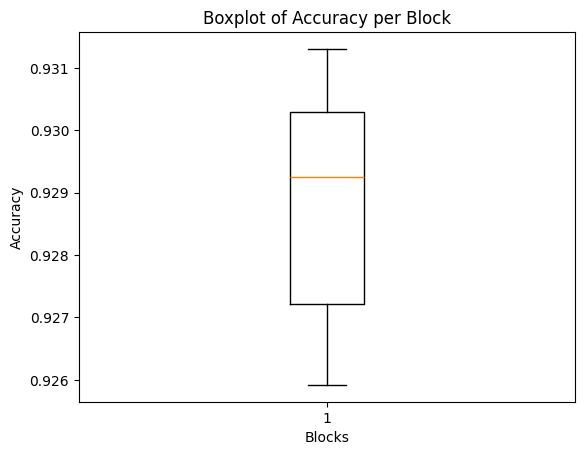

In [7]:
import matplotlib.pyplot as plt
plt.boxplot(all_ac)
plt.xlabel('Blocks')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracy per Block')
plt.show()

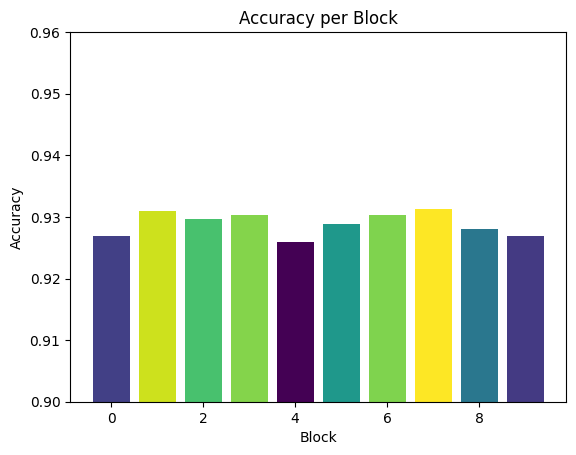

In [8]:
colors = plt.cm.viridis((np.array(all_ac) - min(all_ac)) / (max(all_ac) - min(all_ac)))
plt.bar(range(num_blocks_cv), all_ac, color=colors)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy per Block')
plt.ylim(0.90, 0.96)
plt.show()


# Memoria parte 1

In [5]:
def ej1_train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    costs = []
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        costs.append(loss)
    return w, b, costs

Learning rates: 100%|██████████| 7/7 [35:23<00:00, 303.30s/it]                  


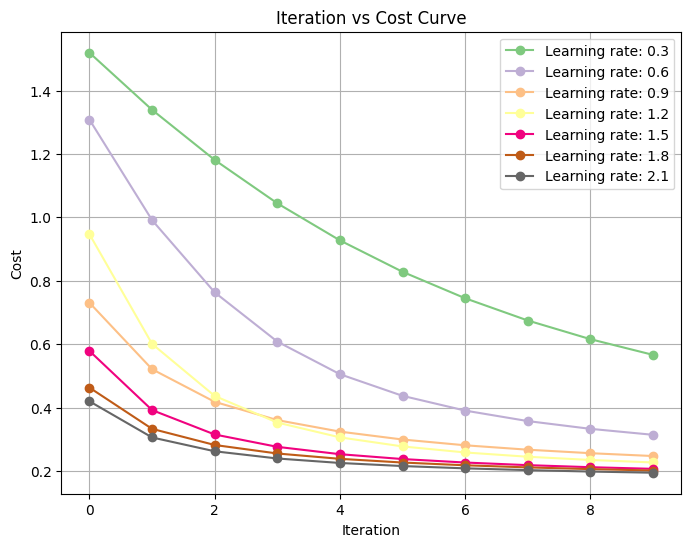

In [6]:
n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_tot_syn_l.csv')

normalizado = normalize(n)
total_costs=[]
learning_rates=[0.3,0.6,0.9,1.2,1.5,1.8,2.1]

colors = plt.cm.Accent((np.array(learning_rates) - min(learning_rates)) / (max(learning_rates) - min(learning_rates)))
lambda_reg=0
plt.figure(figsize=(8, 6))
for learning_rate in tqdm(learning_rates, desc=f"Learning rates"):
    w,b,costs=ej1_train(normalizado,10,learning_rate,0)
    total_costs.append(costs)

    plt.plot(costs, marker='o', linestyle='-',color=colors[learning_rates.index(learning_rate)],label=f"Learning rate: {learning_rate}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_learning_rate_million.png")  # Guardar imagen
plt.show()

Lambdas:   0%|          | 0/7 [00:00<?, ?it/s]                                  

0


Lambdas:  14%|█▍        | 1/7 [04:58<29:48, 298.03s/it]                         

0.1


Lambdas:  29%|██▊       | 2/7 [10:01<25:06, 301.28s/it]                         

0.2


Lambdas:  43%|████▎     | 3/7 [15:00<20:00, 300.07s/it]                         

0.3


Lambdas:  57%|█████▋    | 4/7 [20:06<15:07, 302.49s/it]                         

0.4


Lambdas:  71%|███████▏  | 5/7 [25:05<10:02, 301.15s/it]                         

0.5


Lambdas:  86%|████████▌ | 6/7 [30:12<05:03, 303.09s/it]                         

0.6


Lambdas: 100%|██████████| 7/7 [35:13<00:00, 301.91s/it]                         


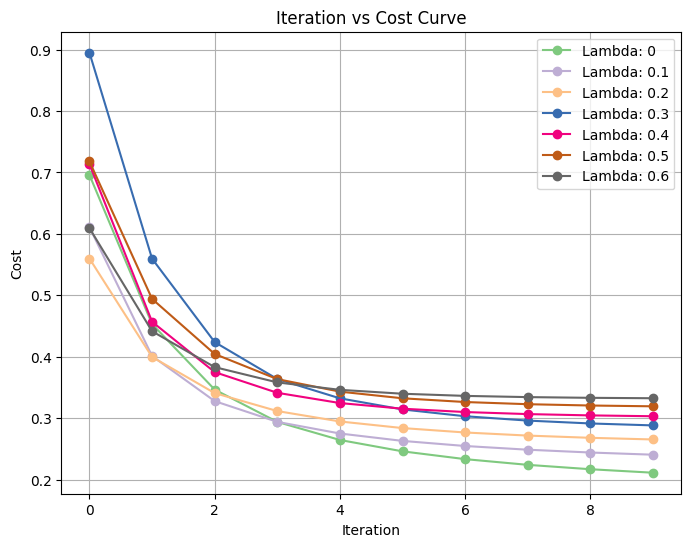

In [7]:
n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_tot_syn_l.csv')

normalizado = normalize(n)
lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6]

colors = plt.cm.Accent((np.array(lambdas) - min(lambdas)) / (max(lambdas) - min(lambdas)))
plt.figure(figsize=(8, 6))
for lamb in tqdm(lambdas, desc=f"Lambdas"):
    print(lamb)
    w,b,costs=ej1_train(normalizado,10,1.5,lamb)

    plt.plot(costs, marker='o', linestyle='-',color=colors[lambdas.index(lamb)],label=f"Lambda: {lamb}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_lambda_million.png")  # Guardar imagen
plt.show()

## Memoria Parte 2

Workers:   0%|          | 0/15 [00:00<?, ?it/s]Exception in thread "serve RDD 5" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
Workers: 100%|██████████| 15/15 [03:59<00:00, 15.96s/it]                        


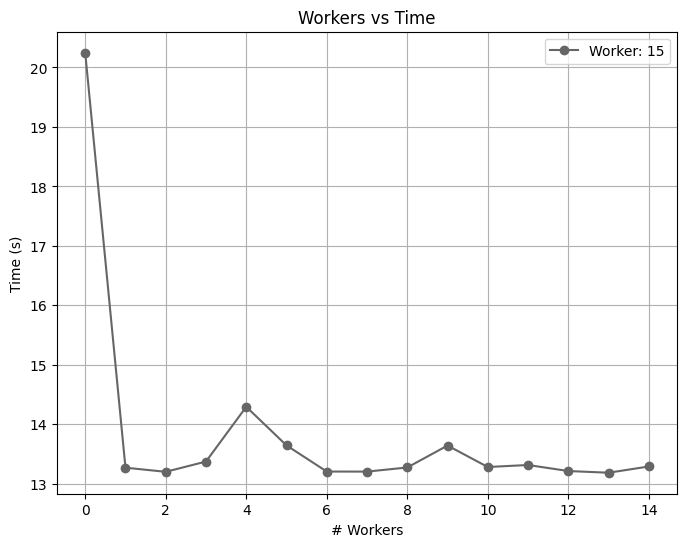

In [ ]:

n_worker=4
workers=range(1,n_worker+4)

try:
    sc.stop()
except:
    pass
totals=[]
plt.figure(figsize=(8, 6))
for worker in tqdm(workers, desc=f"Workers"):
    print(worker)
    sc = SparkContext(f"local[{worker}]", "Name of the Program")
    n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_tot_syn_l.csv')   
    normalizado = normalize(n)
    inicio=time.time()
    w,b,costs=ej1_train(normalizado,10,1.5,0)
    fin=time.time()
    sc.stop()
    totals.append(fin-inicio)

plt.plot(range(1, len(totals) + 1), totals, marker='o', linestyle='-')
plt.xlabel("# Workers")
plt.ylabel("Time (s)")
plt.title("Workers vs Time")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_2_time_workers_million.png") 
plt.show()

## Memoria Parte 4

Partitions: 100%|██████████| 2/2 [00:21<00:00, 10.50s/it]                       


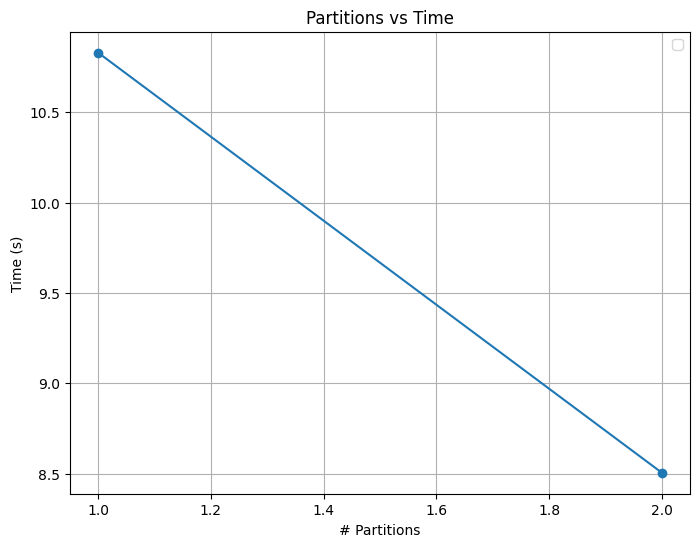

In [ ]:
partitions=range(1,9)


try:
    sc.stop()
except:
    pass
sc = SparkContext(f"local[{4}]", "Name of the Program")
totals=[]
plt.figure(figsize=(8, 6))
for partition in tqdm(partitions, desc=f"Partitions"):
    print(partition)
    n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_tot_syn_l.csv')   
    normalizado = normalize(n)
    normalizado=normalizado.repartition(partition)

    inicio=time.time()
    w,b,costs=ej1_train(normalizado,10,1.5,0)
    fin=time.time()
    totals.append(fin-inicio)

plt.plot(range(1, len(totals) + 1), totals, marker='o', linestyle='-')
plt.xlabel("# Partitions")
plt.ylabel("Time (s)")
plt.title("Partitions vs Time")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_4_time_partitions_million.png") 
plt.show()